In [1]:
import statsapi
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os

# Hard-coded list of MLB team names
mlb_teams = ["Arizona Diamondbacks", "Atlanta Braves", "Baltimore Orioles", "Boston Red Sox", "Chicago Cubs",
             "Chicago White Sox", "Cincinnati Reds", "Cleveland Guardians", "Colorado Rockies", "Detroit Tigers",
             "Houston Astros", "Kansas City Royals", "Los Angeles Angels", "Los Angeles Dodgers", "Miami Marlins",
             "Milwaukee Brewers", "Minnesota Twins", "New York Mets", "New York Yankees", "Oakland Athletics",
             "Philadelphia Phillies", "Pittsburgh Pirates", "San Diego Padres", "San Francisco Giants", "Seattle Mariners",
             "St. Louis Cardinals", "Tampa Bay Rays", "Texas Rangers", "Toronto Blue Jays", "Washington Nationals"]

def parse_box_score(box_score):
    """Parse traditional box score string into structured data, ensuring team names are correctly extracted."""
    lines = box_score.strip().split('\n')
    headers = re.findall(r'\d+', lines[0])
    team_scores = {}
    for line in lines[1:]:
        parts = line.split()
        team_name_pattern = r'^[A-Za-z\s]+'
        team_name_match = re.match(team_name_pattern, line)
        if team_name_match:
            team_name = team_name_match.group().strip()
            if team_name in mlb_teams:
                remaining_parts = line[len(team_name):].strip().split()
                scores = remaining_parts[:len(headers)]
                runs, hits, errors = remaining_parts[len(headers):len(headers)+3]
                team_scores[team_name] = {
                    'Inning Scores': scores,
                    'Runs': runs,
                    'Hits': hits,
                    'Errors': errors
                }
    return team_scores


# Define the period for analysis
start_date = '2024-03-01'
end_date = '2024-5-10'

# Fetch schedule for all games played between start_date and end_date
sched = statsapi.schedule(start_date=start_date, end_date=end_date)

# Prepare data for DataFrame
data = []

# Process each game in the schedule
for game in sched:
    game_id = game['game_id']
    print(f"Fetching linescore for game ID {game_id}")
    
    try:
        linescore = statsapi.linescore(game_id)
        if isinstance(linescore, str):  # Assuming linescore returns a string format
            parsed_data = parse_box_score(linescore)
            # Append data for each team
            for team, stats in parsed_data.items():
                for inning, score in enumerate(stats['Inning Scores'], start=1):
                    data.append((team, game_id, 'Offensive', inning, int(score)))
                # Derive defensive data (scores of the opponent)
                for opponent_team, opponent_stats in parsed_data.items():
                    if team != opponent_team:
                        for inning, score in enumerate(opponent_stats['Inning Scores'], start=1):
                            data.append((team, game_id, 'Defensive', inning, int(score)))
        else:
            print("Invalid format or missing innings data")
    except Exception as e:
        print(f"Error fetching linescore for game ID {game_id}: {e}")

# Creating the DataFrame
columns = ['Team', 'Game ID', 'Type', 'Inning', 'Score']
df = pd.DataFrame(data, columns=columns)

# Filter for offensive scores in the first inning
first_inning_df = df[(df['Type'] == 'Offensive') & (df['Inning'] == 1)]

# Group by team and game, and calculate average first inning score
avg_first_inning_scores = first_inning_df.groupby(['Team', 'Game ID']).agg({'Score': 'mean'}).reset_index()

# Sort by game ID for plotting
avg_first_inning_scores.sort_values(by='Game ID', inplace=True)

# Plotting
plt.figure(figsize=(14, 8))
teams = avg_first_inning_scores['Team'].unique()
for team in teams:
    team_data = avg_first_inning_scores[avg_first_inning_scores['Team'] == team]
    team_data['MA Score'] = team_data['Score'].rolling(window=15).mean()  # Calculate moving average
    plt.plot(team_data['Game ID'], team_data['MA Score'], marker='', linestyle='-', label=f'{team}')

plt.title('Moving Average of First Inning Offensive Scores for All MLB Teams')
plt.xlabel('Game ID')
plt.ylabel('Moving Average Score')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Fetching linescore for game ID 748165
Fetching linescore for game ID 748162
Fetching linescore for game ID 748161
Fetching linescore for game ID 748164
Fetching linescore for game ID 748160
Fetching linescore for game ID 748166
Fetching linescore for game ID 748159
Fetching linescore for game ID 748154
Fetching linescore for game ID 748151
Fetching linescore for game ID 748153
Fetching linescore for game ID 748158
Fetching linescore for game ID 748152
Fetching linescore for game ID 748155
Fetching linescore for game ID 748163
Fetching linescore for game ID 748156
Error fetching linescore for game ID 748156: invalid literal for int() with base 10: '-backs'
Fetching linescore for game ID 748157
Fetching linescore for game ID 748150
Fetching linescore for game ID 748147
Fetching linescore for game ID 748145
Fetching linescore for game ID 748148
Fetching linescore for game ID 748146
Fetching linescore for game ID 748141
Fetching linescore for game ID 748144
Fetching linescore for game ID 7

KeyboardInterrupt: 

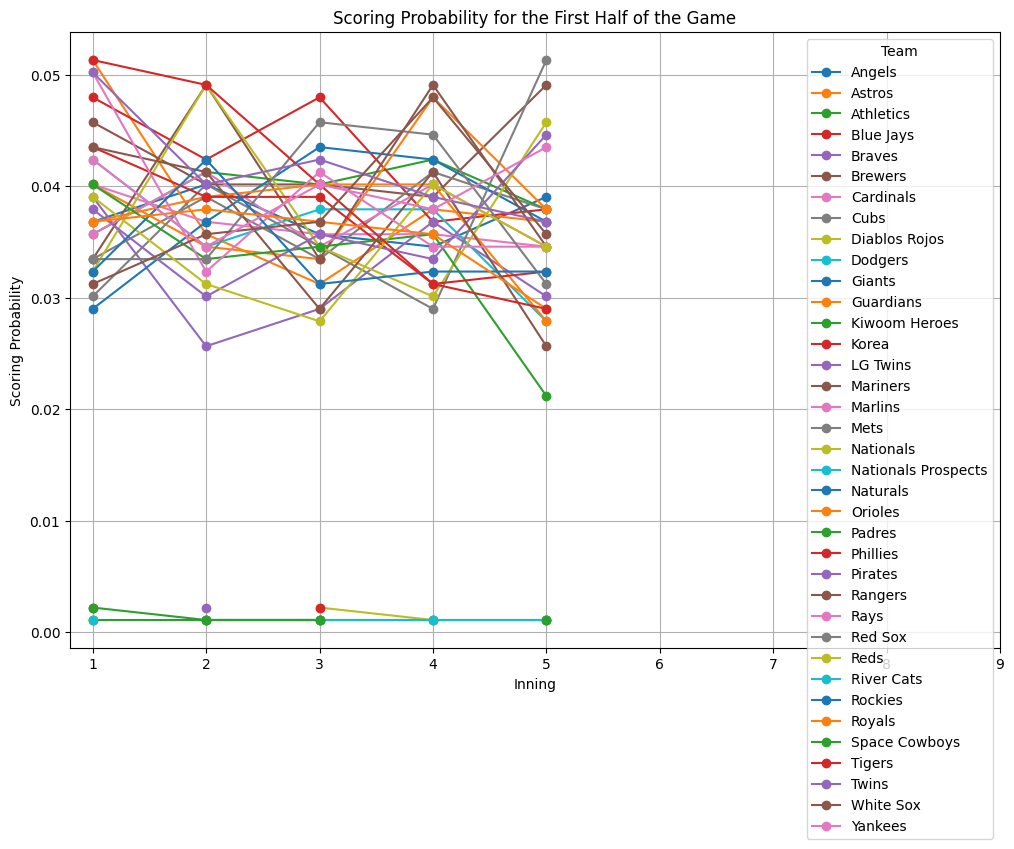

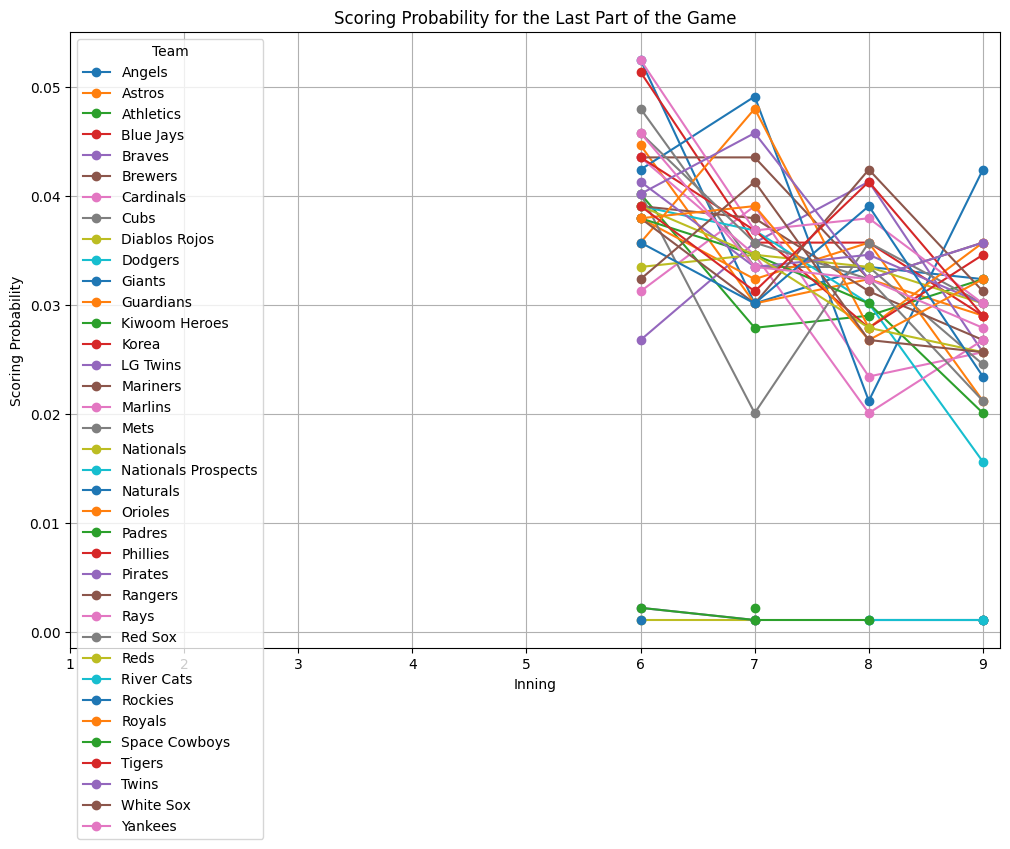

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is already loaded and contains the inning scores for each team as per previous part of your script

# Splitting the DataFrame into first and last parts of the game
first_half = df[df['Inning'].isin([1, 2, 3, 4, 5])]
last_part = df[df['Inning'].isin([6, 7, 8, 9])]

# Function to calculate scoring probability
def calculate_scoring_probability(df):
    # Calculate the probability of scoring in each inning
    total_games = df['Game ID'].nunique()
    score_prob = df[df['Score'] > 0].groupby(['Team', 'Inning']).size().reset_index(name='Scoring Count')
    score_prob['Probability'] = score_prob['Scoring Count'] / total_games
    return score_prob.pivot(index='Team', columns='Inning', values='Probability')

# Scoring probability for first half and last part
first_half_prob = calculate_scoring_probability(first_half)
last_part_prob = calculate_scoring_probability(last_part)

# Function to plot probability
def plot_probabilities(prob_df, title):
    plt.figure(figsize=(12, 8))
    teams = prob_df.index
    for team in teams:
        plt.plot(prob_df.columns, prob_df.loc[team], marker='o', linestyle='-', label=f'{team}')
    plt.title(title)
    plt.xlabel('Inning')
    plt.ylabel('Scoring Probability')
    plt.legend(title='Team')
    plt.grid(True)
    plt.xticks(range(1, 10))  # Adjust based on the innings present
    plt.show()

# Plotting
plot_probabilities(first_half_prob, 'Scoring Probability for the First Half of the Game')
plot_probabilities(last_part_prob, 'Scoring Probability for the Last Part of the Game')
